In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
from time import time
from torch.utils.data import Dataset

In [3]:
def plot_accuracy_loss(training_results):
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.show()

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

def show_dataComp(data_sample,y):
    plt.subplot(1,2,1)
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(data_sample[1].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(y))

    plt.show()

In [4]:
def indlist(target):
    indlist = [[],[],[],[],[]]
    
    for i in range(len(target)):
        if target[i] < 5:
            indlist[target[i]].append(i)
    return indlist

def subData(dataSet):
    #gets all the indices of the data obsv with same y from the dataset that is passed in only for 0-4
    indices = indlist(dataSet.targets)
    # a list of datasets where each dataset has the data for the same number
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    return subsets
    

In [12]:
def comparisonDataConsecutive(dataSet):
    subsets = subData(dataSet)
    # a list of the size of the possible pairs
    comp = []
    for indi in range(len(subsets) - 1):
        comp.append(int(min(len(subsets[indi]), len(subsets[indi + 1]))))
    tot1 = sum(comp)
    # img pair data stored
    x = torch.zeros([tot1, 2, 28, 28], dtype=torch.float32)
    # greater than or less than label stored
    y = torch.zeros([tot1,1])
    # 1 for first pic greater, 0 for first pic less
    k = 0
    # does the actual pairing
    for i in range(len(subsets) - 1):
        for j in range(int(comp[i] / 2)):
            x[k][0] = subsets[i][j][0]
            x[k][1] = subsets[i + 1][j][0]
            y[k][0] = 0
            k += 1
        for j in range(int(comp[i] / 2), comp[i]):
            x[k][1] = subsets[i][j][0]
            x[k][0] = subsets[i + 1][j][0]
            y[k][0] = 1
            k += 1
    return x,y

In [13]:
def comparisonDataNonconsecutive(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 2):
        for j in range(i + 2, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    k = 0
    #the pairing
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            k += 1
    return x,y


In [14]:
def comparisonAll(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs(tuple) and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 2):
        for j in range(i + 1, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    z = list()
    k = 0
    # the pairining
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            z.append(key)
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            z.append(key)
            k += 1
    return x,y,z

recording activations:
- all pairs
- need to know what the pairing is
    - have a list of pairs in the len of the x, y tensors
    - incorporate it into the dataset

In [15]:
class Trainsetcomp(Dataset):
    def __init__(self, x, y):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.len

In [16]:
class TrainsetcompwithA(Dataset):
    def __init__(self, x, y, z):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 
        #the pair
        self.z = z

    def __getitem__(self, index):
        return (self.x[index], self.y[index], self.z[index])

    def __len__(self):
        return self.len

In [17]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = dsets.MNIST(root='./../data',
                            train=True,
                            download=True,
                            transform=transform)
valset = dsets.MNIST(root='./../data',
                            train=False,
                            download=True,
                            transform=transform)

In [18]:
x, y = comparisonDataConsecutive(trainset)
traindataComp = Trainsetcomp(x,y)
x,y = comparisonDataConsecutive(valset)
valdataComp = Trainsetcomp(x,y)

In [19]:
trainloader = torch.utils.data.DataLoader(traindataComp,
                                          batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataComp,
                                          batch_size=64,
                                          shuffle=True)
x,y,z = comparisonAll(valset)
testdata = TrainsetcompwithA(x,y,z)
testloader = torch.utils.data.DataLoader(testdata,
                                          batch_size=64,
                                          shuffle=True)


1) traindataComp-trainloader: consecutive data pairs from the training set <br>
2) valdataComp-valloader: consecutive data pairs from the test set <br>
3) testdata- testloader: all data pairs from test set- keeps track of the pair <br>

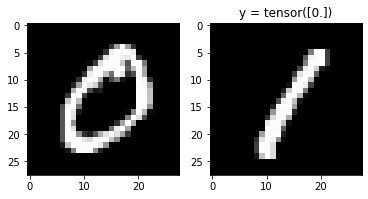

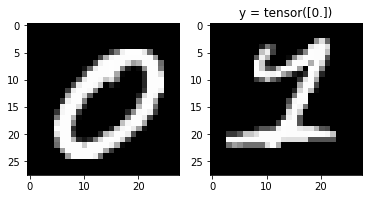

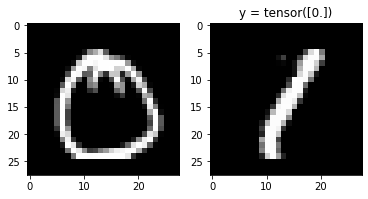

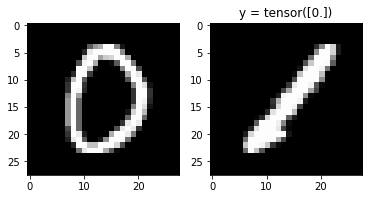

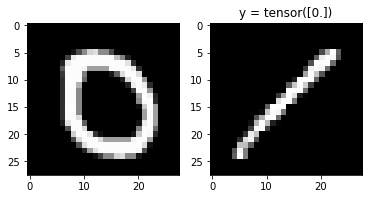

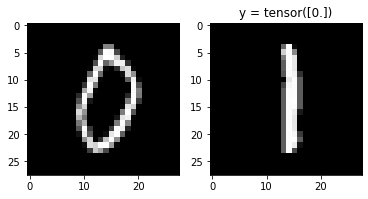

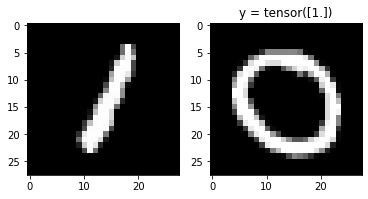

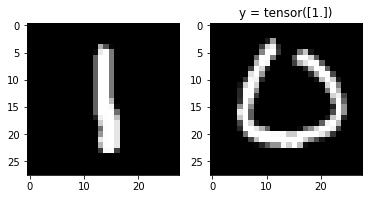

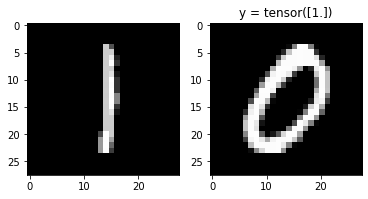

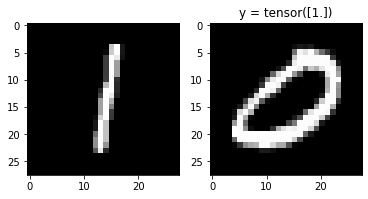

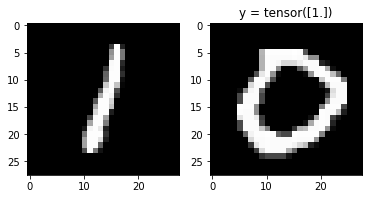

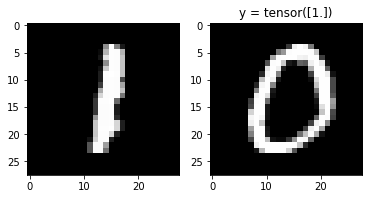

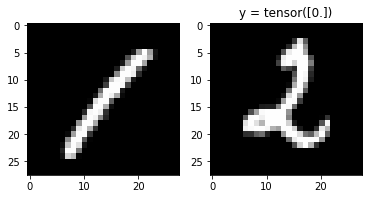

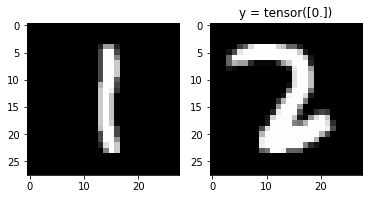

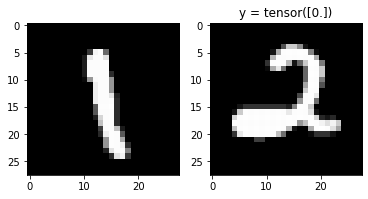

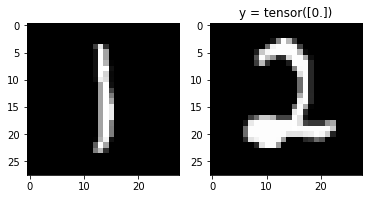

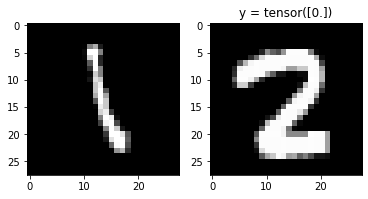

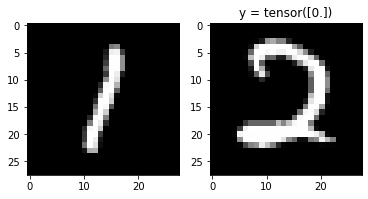

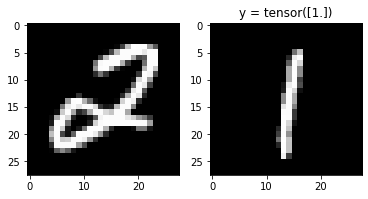

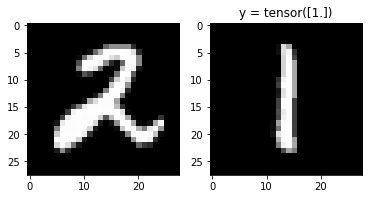

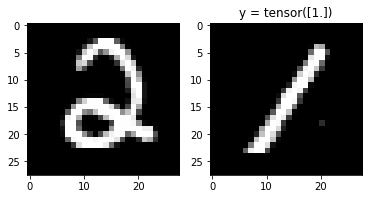

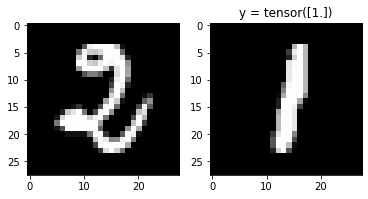

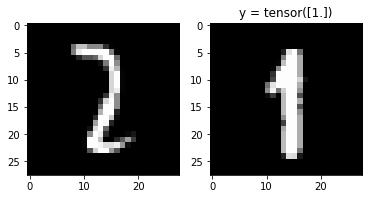

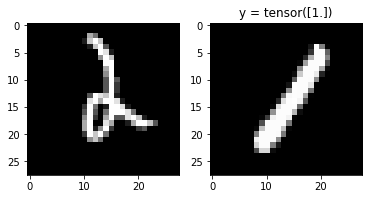

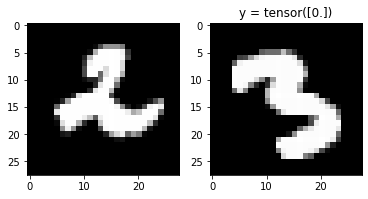

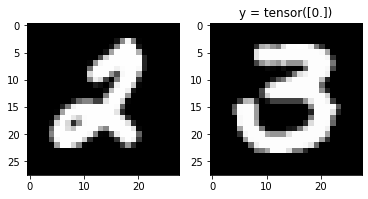

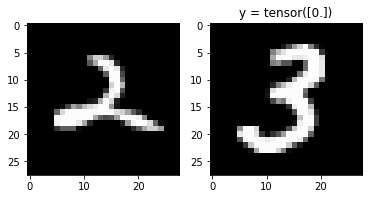

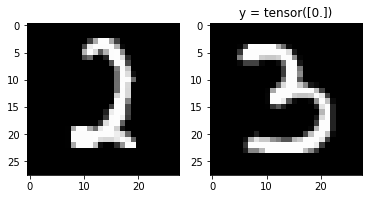

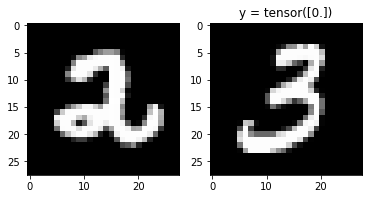

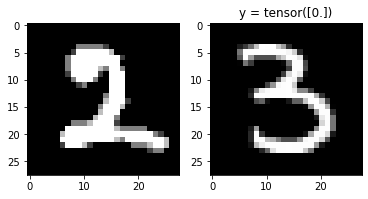

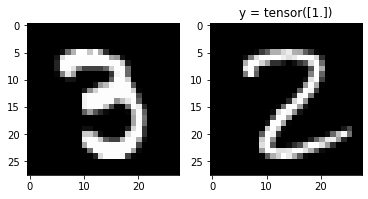

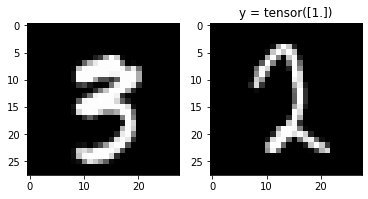

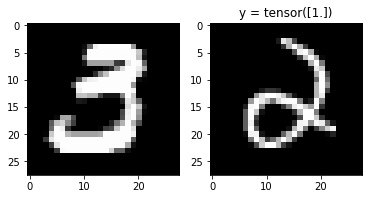

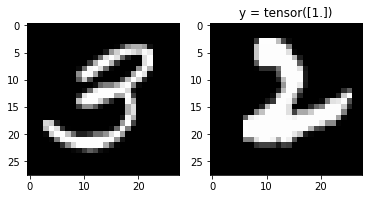

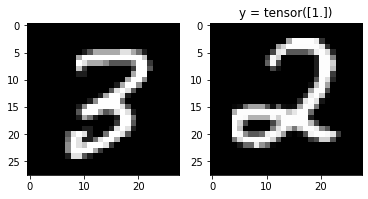

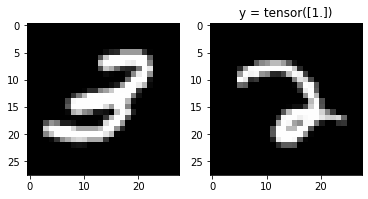

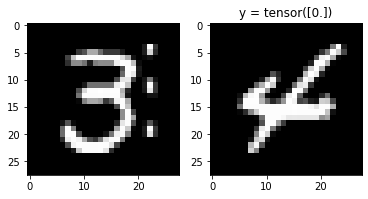

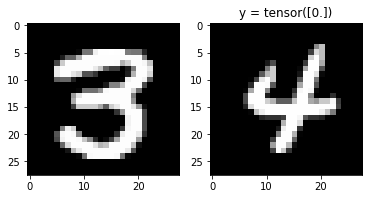

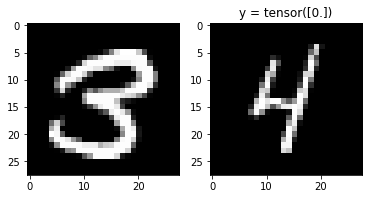

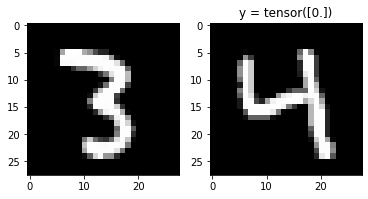

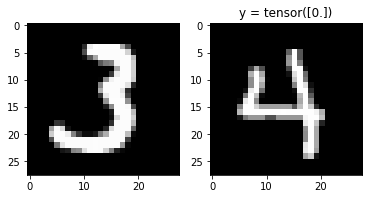

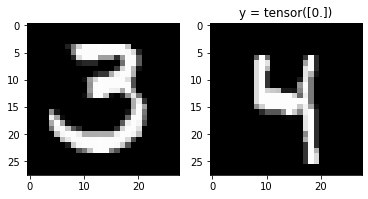

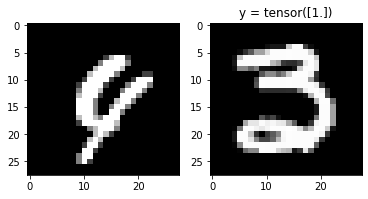

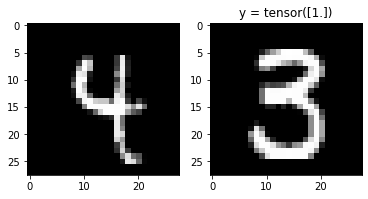

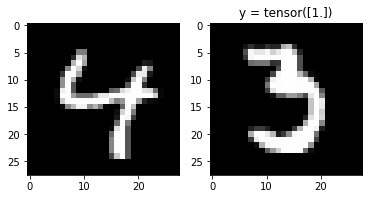

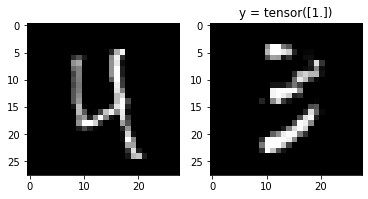

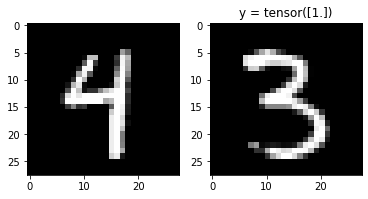

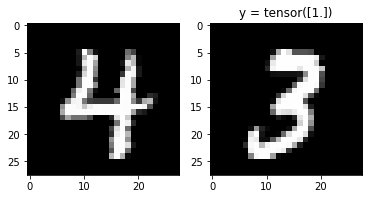

In [23]:
for i in range(0,len(traindataComp),500):
    show_dataComp(traindataComp[i][0], traindataComp[i][1])

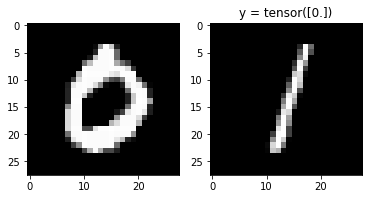

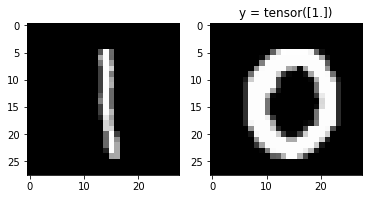

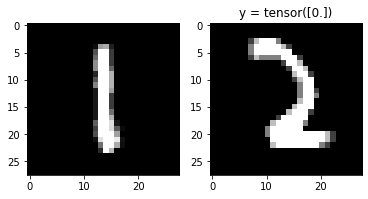

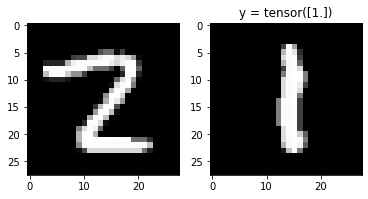

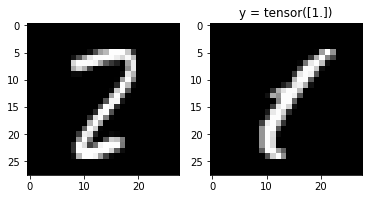

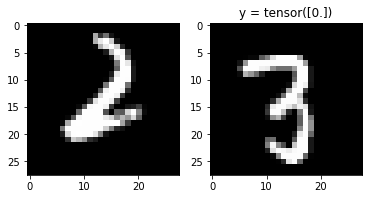

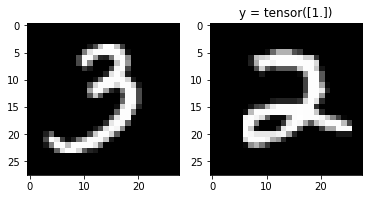

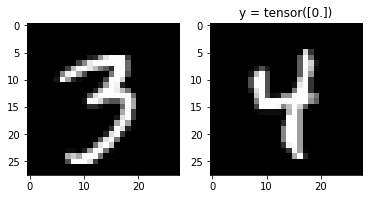

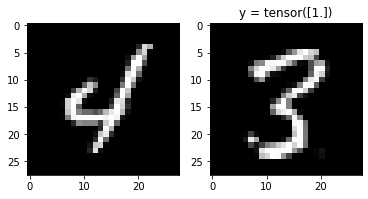

In [24]:
for i in range(0,len(valdataComp),500):
    show_dataComp(valdataComp[i][0], valdataComp[i][1])

8936


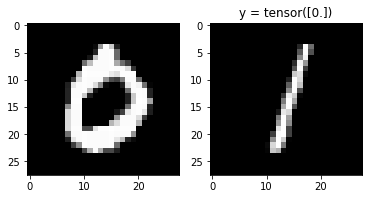

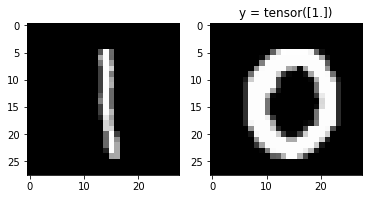

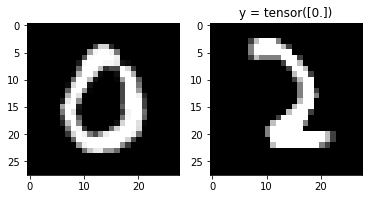

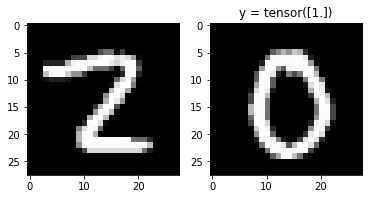

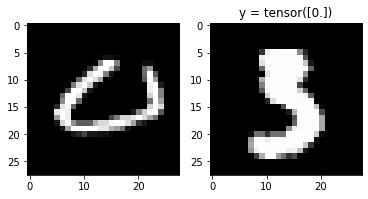

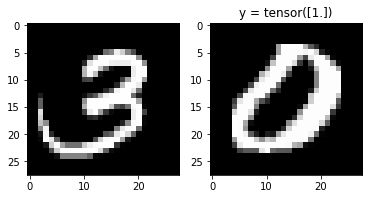

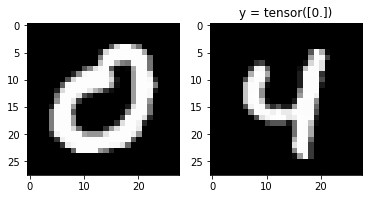

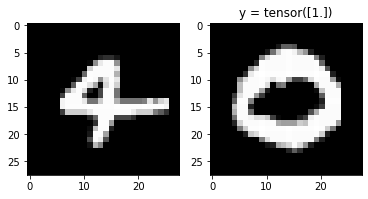

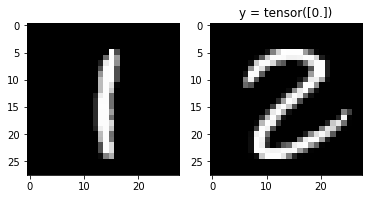

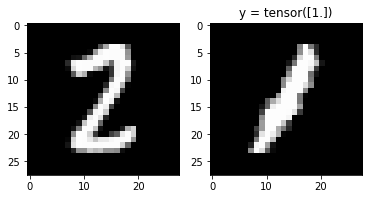

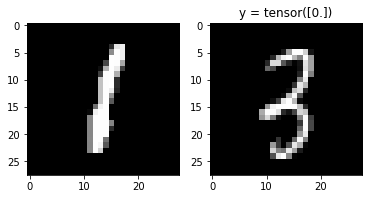

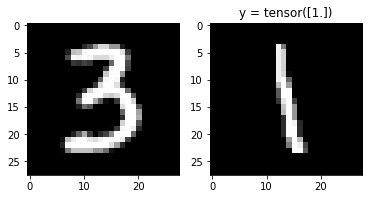

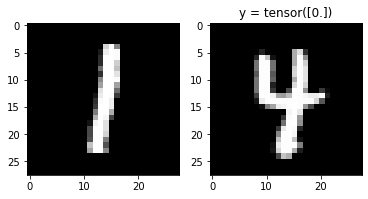

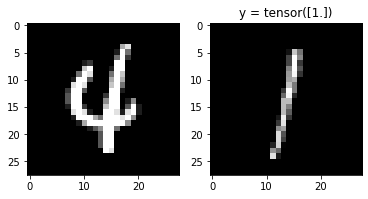

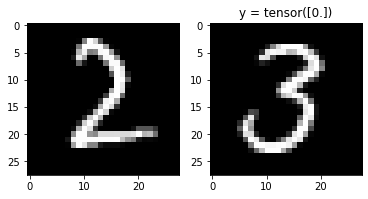

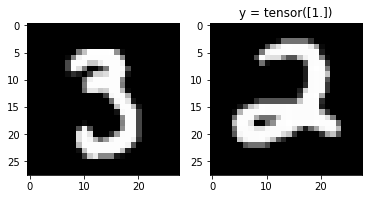

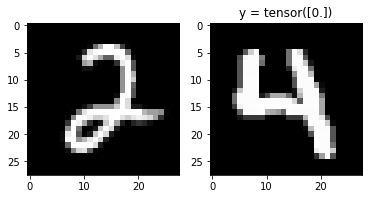

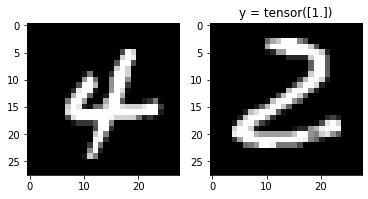

In [25]:
print(len(testdata))
for i in range(0,len(testdata),500):
    show_dataComp(testdata[i][0], testdata[i][1])